In [1]:
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms

/storage/conda/envs/env_qc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dataset import PascalPartDataset
# from lightning_module import PascalPartModel
from pose_estimation_sam_module import PascalPartModel


In [4]:
# Set random seeds for reproducibility
seed = 42
pl.seed_everything(seed=seed, workers=True)

# Specify experiment details
project = 'PascalPart'  # Update this with your project name
port = '3033'  # Update this if needed
experiment_name = project

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [5]:
# Set the tracking URI for mlflow
mlflow.set_tracking_uri(f'http://localhost:{port}')
mlflow.set_experiment(experiment_name)

# Fetch the experiment details
experiment = mlflow.get_experiment_by_name(experiment_name)

# Load the best model from the mlflow experiment
# best_run = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=['metrics.val_loss ASC']).iloc[0]
best_run = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=['start_time DESC']).iloc[0]
best_model_uri = best_run.artifact_uri + '/model'
model = mlflow.pytorch.load_model(best_model_uri)

In [6]:
best_run

run_id                                                       1157592306ea4cd0bae28a41980ac118
experiment_id                                                                               1
status                                                                               FINISHED
artifact_uri                                /storage/AIDA_PROJECTS/egor.koptelov/MIL_test_...
start_time                                                   2024-08-23 11:03:29.596000+00:00
end_time                                                     2024-08-23 15:46:24.318000+00:00
metrics.val_loss_epoch                                                               0.783352
metrics.train_jaccard_index_mIoU_2_epoch                                             0.666627
metrics.train_jaccard_index_mIoU_2                                                   0.666627
metrics.train_jaccard_loss_mIoU_2                                                    0.881244
metrics.train_loss_step                                     

In [7]:
# # upload model from checkpoints
# model = PascalPartModel
# model = mlflow.pytorch.load_checkpoint(model, best_run.run_id)

In [8]:
df_train_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})
df_val_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})

# extract names of images and masks for train and val splts
splits = ["train_id", "val_id"]
splits_samples = {}

for split in splits:
    with open(f'/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/hierarchical_segmentation/data/{split}.txt') as f:
        splits_samples[split] = f.read().splitlines()

path_to_raw = '/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/Pascal-part'

# create dataframes with full paths to images and masks
df_train_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['train_id']]
df_train_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['train_id']]
df_val_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['val_id']]
df_val_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['val_id']]

In [9]:
transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
            # max_pixel_value=255.0,
        ),
        ToTensorV2()
    ])

In [10]:
# extract transform
transform = model.transform
mean, std = transform[1].mean, transform[1].std

# Create the validation dataset and dataloader
val_dataset = PascalPartDataset(df_val_paths, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

train_dataset = PascalPartDataset(df_train_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [11]:
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

In [12]:
# Visualize a few samples
def visualize_predictions(model, dataloader, num_samples, std, mean):
    model.eval()

    with torch.no_grad():
        for i, (image, mask) in enumerate(val_loader):
            if i >= num_samples:
                break
            
            # Forward pass through the model
            body_output, upper_lower_body_output, body_parts_output = model(image)
            
            # Convert model outputs to predictions
            body_pred = torch.argmax(body_output, dim=1)  # torch.sigmoid(body_output) > 0.5
            upper_lower_pred = torch.argmax(upper_lower_body_output, dim=1) # torch.sigmoid(upper_lower_body_output) > 0.5
            body_parts_pred = torch.argmax(body_parts_output, dim=1)
            

            denorm_image = denormalize(image[0], mean, std)
            # Visualize the results
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 5, 1)
            plt.title('Input Image')
            plt.imshow(denorm_image.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')

            plt.subplot(1, 5, 2)
            plt.title('Ground Truth Mask')
            plt.imshow(mask[0].permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            plt.subplot(1, 5, 3)
            plt.title('Predicted Body Mask')
            plt.imshow(body_pred.permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            plt.subplot(1, 5, 4)
            plt.title('Predicted Up/Low Body Mask')
            plt.imshow(upper_lower_pred.permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            plt.subplot(1, 5, 5)
            plt.title('Predicted Body parts Mask')
            plt.imshow(body_parts_pred.permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            plt.show()

/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/hierarchical_segmentation/pose_estimation_sam_module.py:210: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_mask = torch.tensor(final_mask).to(device)


-1 -1


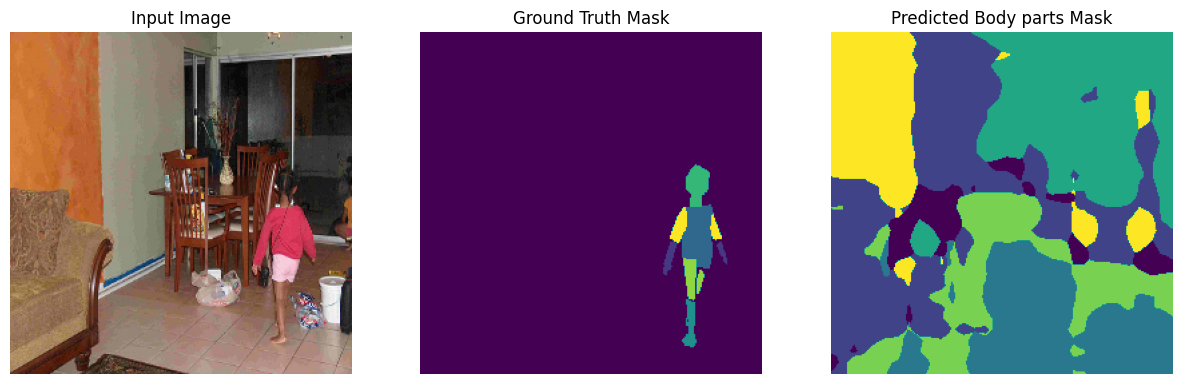

-1 -1


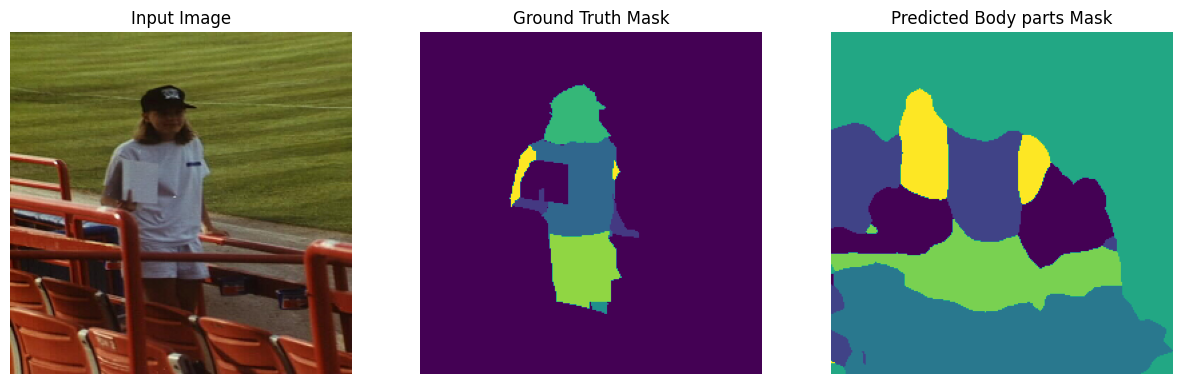

-1 -1


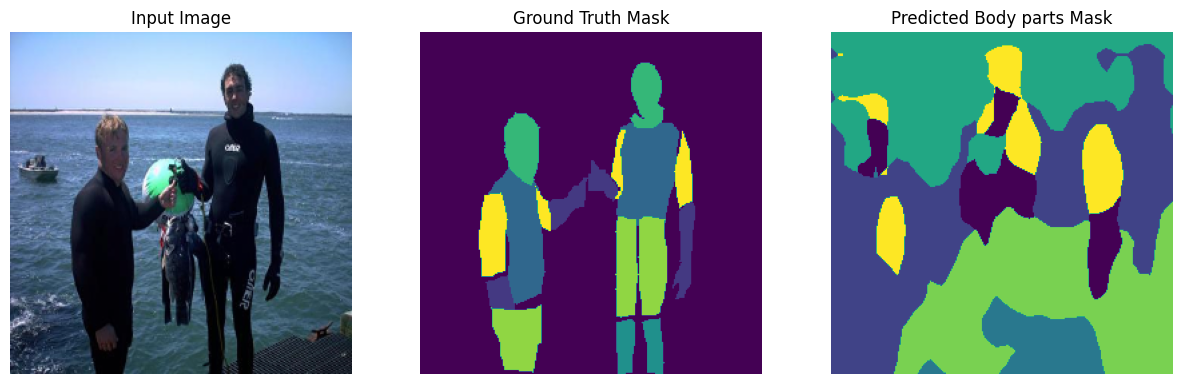

-1 -1


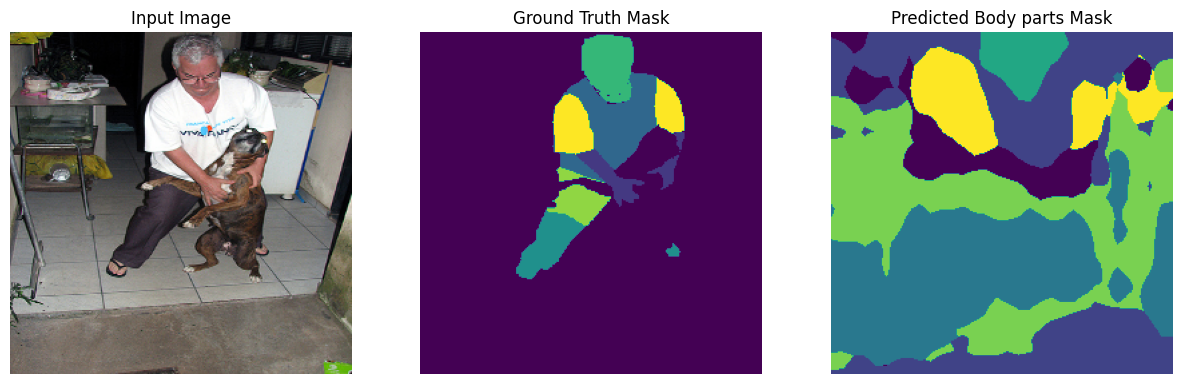

-1 -1


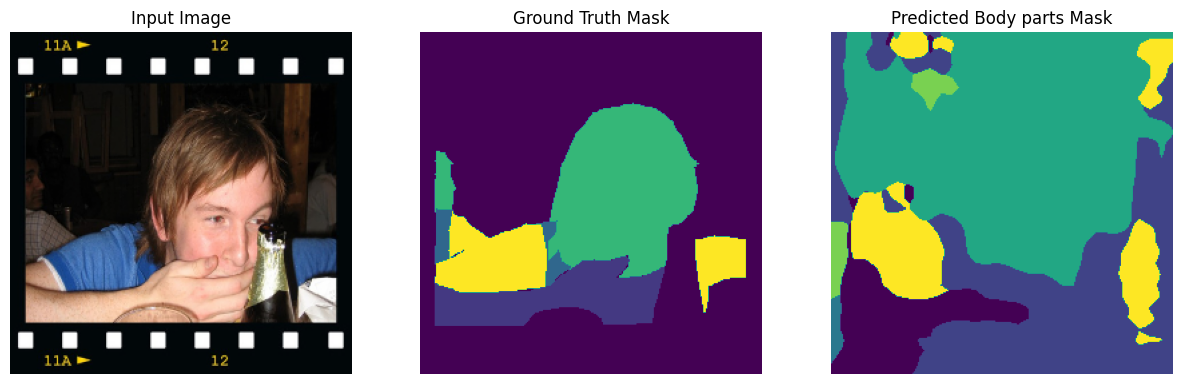

In [25]:
num_samples=5

# model.eval()

# with torch.no_grad():
for i, (image, mask) in enumerate(val_loader):
    if i >= num_samples:
        break
    
    # Forward pass through the model
    body_parts_output = model(image)
    
    # Convert model outputs to predictions
    # body_pred = torch.argmax(body_output, dim=1)  # torch.sigmoid(body_output) > 0.5
    # upper_lower_pred = torch.argmax(upper_lower_body_output, dim=1) # torch.sigmoid(upper_lower_body_output) > 0.5
    body_parts_pred = torch.argmax(body_parts_output, dim=1)
    

    denorm_image = denormalize(image[0], mean, std)
    # Visualize the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(denorm_image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(mask[0].permute(1, 2, 0).cpu().numpy(), 
                # cmap='gray'
    )
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Body parts Mask')
    plt.imshow(body_parts_pred.permute(1, 2, 0).cpu().numpy(), 
                # cmap='gray'
    )
    plt.axis('off')

    plt.show()